BSM price: 7.386031276905224
European option: 7.402372814889219
American option: 7.485855117061496


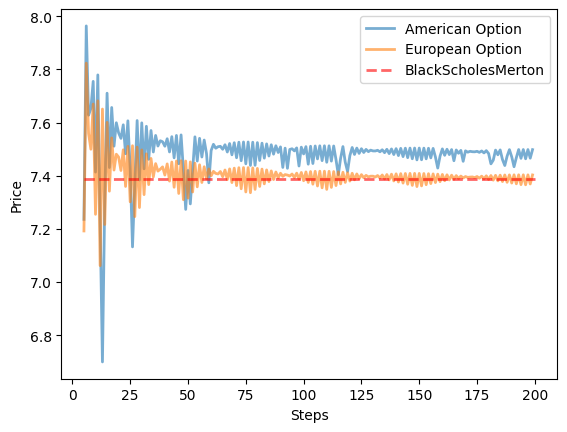

In [ ]:
import pandas as pd 
import datetime
import QuantLib as ql
import matplotlib.pyplot as plt
from statistics import mean
import ivolatility as ivol
import os

# Script description: https://www.ivolatility.com/api/docs#section/Python-Examples/Options-pricing-with-QuantLib

ivolApiKey = os.getenv('API_KEY')
ivol.setLoginParams(apiKey=ivolApiKey)

period = 360
OTMpct = 20
optType = 'C'
date_str = '2022-06-30'
date = datetime.datetime.strptime(date_str, '%Y-%m-%d')

option_type = ql.Option.Call
calculation_date = ql.Date(date.day, date.month, date.year)
maturity_date = calculation_date + period

getMarketData = ivol.setMethod('/equities/eod/stock-prices')
spot_price = getMarketData(symbol='AAPL', from_=date_str, to=date_str).at[0, 'close']

getMarketData = ivol.setMethod('/equities/eod/ivs')
marketData = getMarketData(symbol='AAPL', from_=date_str, to=date_str)
marketData['period'] = pd.to_numeric(marketData['period'])
marketData = marketData.loc[(marketData['Call/Put'] == optType) & (marketData['out-of-the-money %'] == OTMpct) & (marketData['period'] == period)]

strike_price = marketData['strike'].values[0]
volatility = marketData['IV'].values[0]
dividend_rate =  0.023
risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
# calendar = ql.UnitedStates()
# calendar = ql.UnitedStates()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
# calendar = ql.UnitedStates(ql.UnitedStates.Market.NYSE)
# calendar = ql.UnitedStates(ql.NullCalendar())

ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date
am_exercise = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)
eu_exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, eu_exercise)
spot_handle = ql.QuoteHandle( ql.SimpleQuote(spot_price) )
flat_ts = ql.YieldTermStructureHandle( ql.FlatForward(calculation_date, risk_free_rate, day_count) )
dividend_yield = ql.YieldTermStructureHandle( ql.FlatForward(calculation_date, dividend_rate, day_count) )
flat_vol_ts = ql.BlackVolTermStructureHandle( ql.BlackConstantVol(calculation_date, calendar, volatility, day_count) )
bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)

def binomial_price(option, process, steps):
  binomial_engine = ql.BinomialVanillaEngine(process, 'crr', steps)
  option.setPricingEngine(binomial_engine)
  return option.NPV()

steps = range(5, 200, 1)
eu_prices = [binomial_price(european_option, bsm_process, step) for step in steps]
am_prices = [binomial_price(american_option, bsm_process, step) for step in steps]

#theoretical European option price 
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bsm_price = european_option.NPV()

print('BSM price:', bsm_price)
print('European option:', mean(eu_prices))
print('American option:', mean(am_prices))

plt.plot(steps, am_prices, label='American Option', lw=2, alpha=0.6)
plt.plot(steps, eu_prices, label='European Option', lw=2, alpha=0.6)
plt.plot([5,200],[bsm_price, bsm_price], 'r--', label='BlackScholesMerton', lw=2, alpha=0.6)
plt.xlabel('Steps')
plt.ylabel('Price')
plt.legend()
plt.show()